In [127]:
# Data API
!pip install yahoo_fin >> /dev/null
!pip install statsmodels >> /dev/null

In [128]:
import pandas as pd
import numpy as np
from collections import Counter
import os

# Data API
import yahoo_fin.stock_info as si

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Cointegration Testing
from statsmodels.tsa.stattools import coint

# Stationarity Testing
from statsmodels.tsa.stattools import adfuller

# Pair Selection 
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [129]:
START_DATE = pd.Timestamp("2016-01-04")
END_DATE = pd.Timestamp("2017-12-29")
TRADING_DAYS = 2*250

In [130]:
sp500_list = si.tickers_sp500()

In [131]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [132]:
data_dir = os.path.join('/','content','gdrive','MyDrive','trading_pairs')
data_path = os.path.join(data_dir, 'S&P500_stock_data.csv')
test_data_path = os.path.join(data_dir, 'S&P500_stock_data_test.csv')
raw_data_path = os.path.join(data_dir, 'S&P500_raw.csv')

In [133]:
!ls gdrive/MyDrive/trading_pairs

'S&P500_raw.csv'  'S&P500_stock_data.csv'  'S&P500_stock_data_test.csv'


In [134]:
data_path

'/content/gdrive/MyDrive/trading_pairs/S&P500_stock_data.csv'

In [135]:
if os.path.isfile(data_path):
    # Load Files
    data = pd.read_csv(data_path)
    test_data = pd.read_csv(test_data_path)
    data = data.set_index('date')
    test_data = test_data.set_index('date')
    raw_data = pd.read_csv(raw_data_path)
    raw_data.reset_index(drop = True, inplace = True)
    raw_data = raw_data.pivot(index = 'date', columns = 'ticker', values = ['high', 'low'])
else:
    # Download Files
    sp500_historical_data = {}
    for ticker in sp500_list:
        try:
            sp500_historical_data[ticker] = si.get_data(ticker, 
                                                        start_date=START_DATE, 
                                                        index_as_date = False,
                                                        end_date=END_DATE,
                                                        interval="1d")
        # Tickers listed later than the period
        except AssertionError:
            print("{} Listed Later".format(ticker))
            continue
        
        # yahoo_fin has issues with some tickers
        except KeyError:
            print("{} Malformed Data".format(ticker))
            continue

    data = pd.concat(sp500_historical_data)
    data.reset_index(drop = True, inplace = True)
    data = data.pivot(index = 'date', columns = 'ticker', values = 'adjclose')
    data, test_data = data[:TRADING_DAYS//2], data[TRADING_DAYS//2:]
    data.to_csv(data_path)
    test_data.to_csv(test_data_path)

    # Process data for daily High/Low
    raw_data =  pd.concat(sp500_historical_data)
    raw_data.reset_index(drop = True, inplace = True)
    raw_data.to_csv(raw_data_path)
    raw_data = raw_data.pivot(index = 'date', columns = 'ticker', values = ['high', 'low'])


# Dealing with missing data

In [136]:
# Truncate all numbers to have at most 3 digits after the decimal.
pd.set_option('precision',3)
data.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
A,250.0,41.479,3.544,33.152,38.266,42.906,44.361,46.402
AAL,250.0,36.647,4.850,24.285,33.676,36.775,39.246,47.969
AAP,250.0,152.243,9.373,133.517,145.108,151.640,158.441,173.310
AAPL,250.0,24.390,1.882,21.067,22.557,24.550,25.961,27.725
ABBV,250.0,48.091,3.166,40.050,45.610,48.785,50.451,53.709
ABC,250.0,75.932,5.319,63.237,72.255,76.817,79.573,93.532
ABMD,250.0,105.020,15.097,71.000,94.395,104.535,117.775,131.740
ABT,250.0,36.852,2.058,32.775,35.276,36.571,38.429,41.350
ACN,250.0,103.547,6.839,84.809,101.484,105.164,108.375,116.266
ADBE,250.0,97.277,7.787,73.850,93.270,97.710,103.500,110.810


We drop tickers that have too much missing entries, which in this implementation means at least 20% of the entries being NaN. The remaining missing values, possibly due to holidays, incomplete information on Yahoo finance or other issues with the data gathering, are filled using the Pandas ```ffill``` method ensuring no Look-Ahead bias.

In [137]:
print('Data shape before:', data.shape)

null_percentage = data.isnull().sum() / data.shape[0]
to_drop = null_percentage[null_percentage > 0.2].index
data.drop(labels=to_drop, axis=1, inplace=True)

print('Data shape after:', data.shape)

# Fill null values
data = data.fillna(method = 'ffill')

Data shape before: (250, 497)
Data shape after: (250, 493)


In [138]:
later_added = data.isnull().any()
later_added = later_added[later_added == True] 
data.drop(labels=later_added.index, axis=1, inplace=True)

print('Shape after removing added later', data.shape)

Shape after removing added later (250, 493)


### Removing Stationary Series

When checking if two price series are cointegrated, it is important to ensure that they are individually not stationary. The goal is a pair of *non-stationary series* whose *linear combination* **is** stationary. We drop all stationary series via Augmented Dickey–Fuller test at the 0.05 significance level.

In [139]:
to_drop = []

for ticker in data.columns:
    pval = adfuller(data[ticker])[1]
    
    if pval < 0.05:
        to_drop.append(ticker)
    

In [140]:
print(len(to_drop))

21


In [141]:
data = data.drop(columns=to_drop)
print(len(data.columns))

472


### Creating Returns and Volatility DF

Traditionally, we are interested in the daily returns, not the prices. 

In [142]:
ret = data.pct_change().mean()*TRADING_DAYS/2
volatility = data.pct_change().std()*np.sqrt(TRADING_DAYS/2)
returns = pd.DataFrame(index =  data.columns)
returns['returns'] = ret.values
returns['volatility'] = volatility.values

returns.head(5)

,returns,volatility
A,0.152,0.234
AAL,0.231,0.365
AAP,0.150,0.270
AAPL,0.153,0.234
ABBV,0.153,0.272


In [143]:
# Scale values
scale = StandardScaler().fit(returns)

scaled_data = pd.DataFrame(scale.fit_transform(returns), 
                           columns = returns.columns, 
                           index = returns.index)
X = scaled_data
X.head()

,returns,volatility
A,-0.255,-0.331
AAL,0.127,0.979
AAP,-0.266,0.035
AAPL,-0.254,-0.331
ABBV,-0.253,0.049


# Clustering of data

A central issue with pair trading strategies is finding cointegrated pairs or, more generaly, tuples of cointegrated price series. Checking every single pair of tickers is computationally taxing and prone to produce many spurious cointegrations. For instance, we have 505 stocks in the S&P, which produces
$$
{505 \choose 2} = (505\times 504)/2 = 127,260
$$
theoretical pairs to check. Even if we test them at the 0.01 significance level, we expect that around $1,200$ pairs will be deemed cointegrated solely by chance.

To reduce the search space we first cluster the stocks and only check for pairs within each cluster.


## K-means via returns and volatilities
After some experimentations we picked the classical ```k-means``` clustering algorithm, which achieved superior silhouette score (see below) when compared to the other ones tested but was also easier to interpret. We cluster the stocks using their returns and volatilities, and the number of clusters is selected via the *Elbow method*.

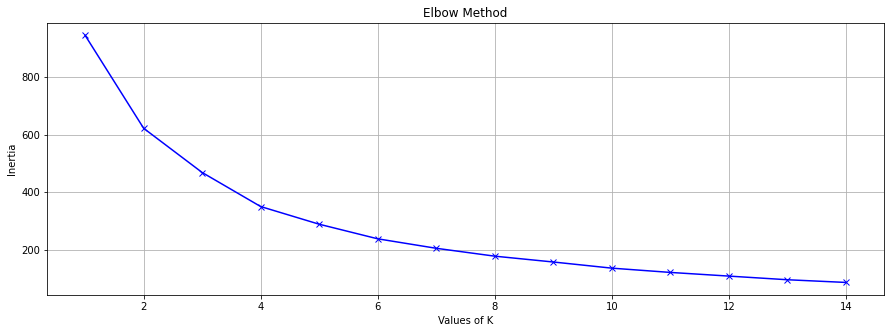

In [144]:

K = range(1,15)
distortions = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
                                        

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

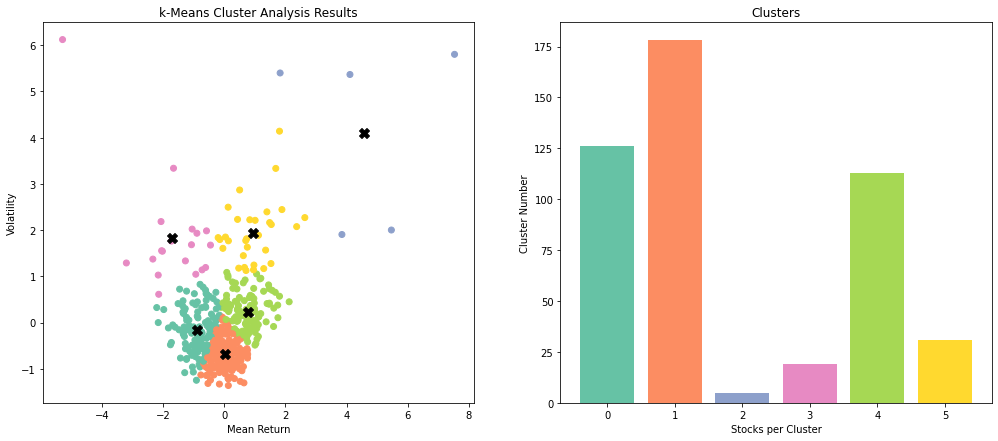

In [145]:
CLUSTERS = 6

# Fit the model
k_means = KMeans(n_clusters=CLUSTERS)
k_means.fit(X)
prediction = k_means.predict(X)
centers = k_means.cluster_centers_

# Plot the results
fig = plt.figure(figsize = (17,7))
colors = cm.get_cmap('Set2')

# Scatter Plot
plt.subplot(1, 2, 1)
plt.scatter(X.iloc[:,0], X.iloc[:,1], c = colors(k_means.labels_), cmap="Set2")
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=1, marker='X')
plt.title('k-Means Cluster Analysis Results')
plt.xlabel('Mean Return')
plt.ylabel('Volatility')

# Cluster Sizes
plt.subplot(1, 2, 2)
cluster_sizes = Counter(k_means.labels_)
counts = sorted(cluster_sizes.items())
x,y = [str(c[0]) for c in counts], [c[1] for c in counts]
plt.bar(x=x, height=y, color = colors([int(i) for i in x]))
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()


Just to experiment a little bit, let us see a few stocks in each cluster.

In [146]:
ticker_to_cluster = pd.Series(index=X.index, data=k_means.labels_)
for i in range(CLUSTERS):
    print("Cluster {}: {}".format(i, np.random.choice(ticker_to_cluster[ticker_to_cluster == i].index, 5)))

Cluster 0: ['LYB' 'ANSS' 'MHK' 'WFC' 'ANTM']
Cluster 1: ['LIN' 'UPS' 'AJG' 'L' 'DUK']
Cluster 2: ['NVDA' 'NVDA' 'OKE' 'WMB' 'OKE']
Cluster 3: ['NOW' 'GPS' 'DXCM' 'ENPH' 'CNC']
Cluster 4: ['EW' 'IPGP' 'NTRS' 'PXD' 'AMAT']
Cluster 5: ['DXC' 'URI' 'ANET' 'SIVB' 'ETSY']


In a previous version we explored other clustering algorithms but picked ```k-means``` due to its superior ```silhouette score```. This score is given by the simple formula

$$
\text{silhouette_score} = \frac{d_{inter}-d_{intra}}{\max(d_{inter},d_{intra})},
$$
where $d_{inter}$ (resp., $d_{intra}$) denote the average inter (resp. intra)-cluster distance.

In [147]:
# Silhouette score for k-means
print("k-Means:", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))

k-Means: 0.35282897415162695


## Finding cointegration pairs in each cluster

We find cointegrated pairs within each cluster using the augmented Engle-Granger test for cointegration at the 0.01 significance level.

In [148]:
counts = ticker_to_cluster.value_counts()
print ("Number of clusters: %d" % len(counts))
print ("Number of Pairs: %d" % ((counts-1)*counts//2).sum()) 

Number of clusters: 6
Number of Pairs: 30602


In [149]:
def get_coint_pairs(ticker_data, significance=0.01):
  '''Computes cointegrated pairs among tickers in ticker_data'''
  N = ticker_data.shape[1]
    
  # We limit this since clusters are rather big
  first_N = 10
  pairs = []
  tickers = ticker_data.keys()
  for i in range(first_N):
      for j in range(i+1, N):
          t1 = ticker_data[tickers[i]]            
          t2 = ticker_data[tickers[j]]
          _, pval, _ = coint(t1, t2)
          if pval < significance:
              pairs.append((tickers[i], tickers[j]))
  return pairs
      
def get_pairs_from_clusters(n_clusters, tikcer_to_cluster, data):
  '''Computes cointegrated pairs for each cluster'''
  cluster_lookup = {}
  for cluster_ix in range(n_clusters):
      tickers_in_cluster = ticker_to_cluster[ticker_to_cluster == cluster_ix].index
      ticker_data = data[tickers_in_cluster]
      pairs = get_coint_pairs(ticker_data)
      cluster_lookup[cluster_ix] = pairs
  return cluster_lookup       

In [150]:
cluster_lookup = get_pairs_from_clusters(CLUSTERS, ticker_to_cluster, data)

# Count Total Pairs
pairs = []
for ix in range(CLUSTERS):
    pairs.extend(cluster_lookup[ix])
print('Total Pairs: {}'.format(len(pairs)))

Total Pairs: 66


In [151]:
# Extract data for tickers in pairs
tickers = np.unique(pairs)
tickers_in_pairs = ticker_to_cluster.loc[tickers]
X_pairs = X.T[tickers].T
X_pairs.head()

,returns,volatility
A,-0.255,-0.331
AAPL,-0.254,-0.331
ABBV,-0.253,0.049
ADI,0.739,-0.318
ADM,0.504,0.218


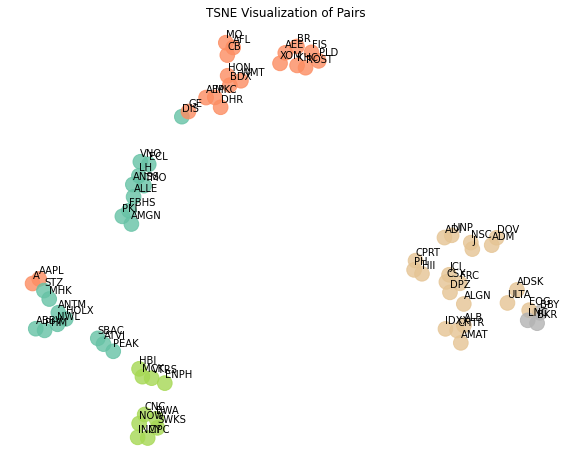

In [152]:
# Use TSNE for visualizations
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)

plt.figure(figsize=(10,8))
plt.axis('off')
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=tickers_in_pairs.values, cmap='Set2')
plt.title('TSNE Visualization of Pairs'); 

for x,y,name in zip(X_tsne[:,0], X_tsne[:,1], X_pairs.index):
    plt.annotate(name, (x,y), textcoords="offset points", xytext=(0,5))
    
plt.show()

# Trading strategy

Before we proceed with the implementation of the strategy, we plot a few of the cointegrated pairs found.

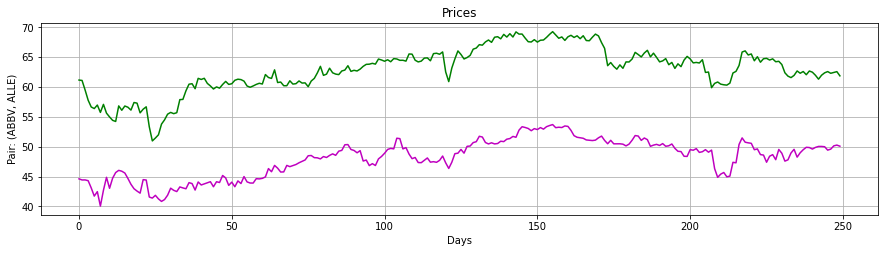

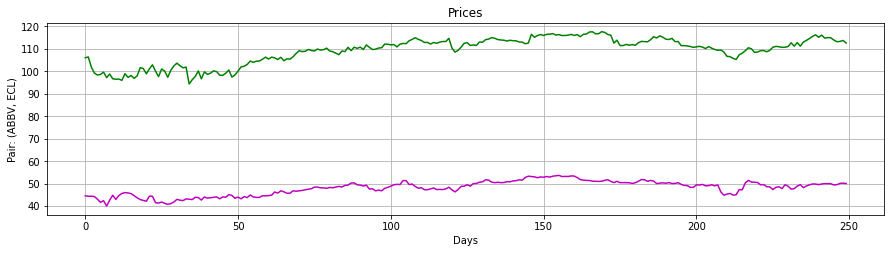

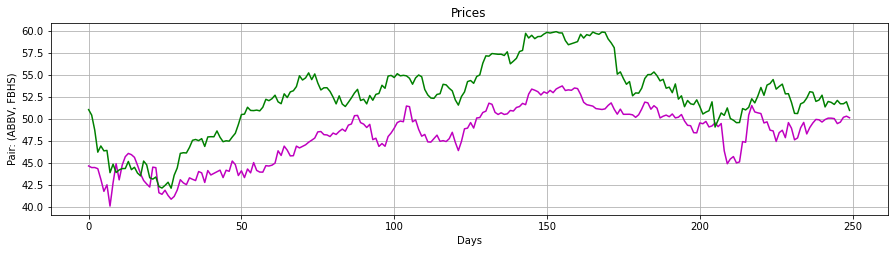

In [153]:
for ix, t in enumerate(pairs[:3]):
    ticker1, ticker2 = t
    df1 = data[ticker1]
    df2 = data[ticker2]
    
    fig = plt.figure(figsize= (15,12))
    plt.subplot(3,1, ix+1)
    plt.plot(range(len(df1)), df1, 'm-')
    plt.plot(range(len(df2)), df2, 'g-')
    plt.xlabel('Days')
    plt.ylabel( "Pair: ({}, {})".format(ticker1, ticker2))
    plt.title('Prices')
    plt.grid()
plt.show()

In comparison, below is a plot two random stocks in the index. 

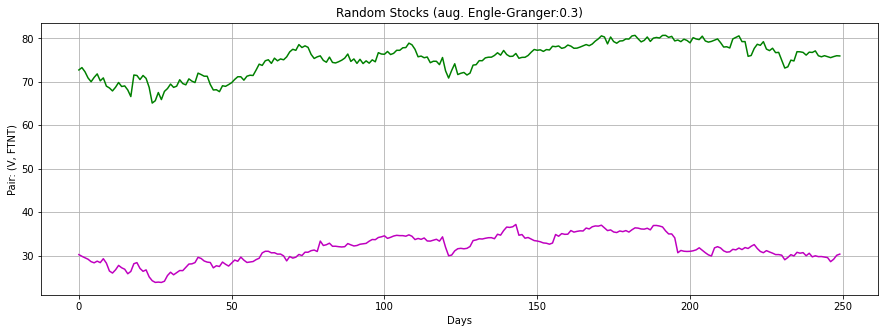

In [154]:
ticker1, ticker2 = np.random.choice(data.columns, 2)
rand_df1 = data[ticker1]
rand_df2 = data[ticker2]

fig = plt.figure(figsize= (15, 5))
plt.plot(range(len(rand_df1)), rand_df1 , 'g-')
plt.plot(range(len(rand_df2)), rand_df2 , 'm-')
plt.xlabel('Days')
plt.ylabel( "Pair: ({}, {})".format(ticker1, ticker2))
plt.title('Random Stocks (aug. Engle-Granger:{})'.format(
    np.around(coint(rand_df1,rand_df2)[1], 2)
))
plt.grid()
plt.show()


### Implementing the strategy 


In [155]:
# Set Hyperparameters
LOOKBACK_PERIOD = 21
FLOOR = -1
CEIL = 1
EXIT = 2.2

#Add Stop Loss 
MAX_PERCENTAGE_LOSS = 50

# TODO
INTEREST_RATE = 0 # maybe update in the future

For a pair of stocks A and B, we need evaluate the spread
$$
\text{spread} = r_A - h_c*r_B,
$$
where $r_i$ is the return of the asset $i$, and $h_c$ is the hedge ratio, assumed constant. We calcuate $h_c$ using regression, so that this spread is as close to $0$ as possible.

Recall that in a simple linear regression
$ Y= \alpha + \beta X+\varepsilon,$ 
the coefficient $\beta$ is given by: 
$$\beta = \text{cov}(X,Y)/\text{var}(X).$$

For each pair we daily evaluate the z-score

$$
z_t = \frac{\text{spread}_t - \mu_{\text{spread}}}{\hat{\sigma}_{\text{spread}}},
$$

where both the mean and the standard deviation are the rolling-estimates for ```LOOKBACK_PERIOD``` periods. When the z-score is big and positive, we go short (short the overperforming and buy the underperforming). Symmetrically, when the z-score is small and negative, we go long. We exit the position when the z-score become abnormally high or low, suggesting a break in the cointegration, or if our losses exceed ```MAX_PERCENTAGE_LOSS```. 



In [156]:
def create_spread(ticker_a, ticker_b,data):
  df1 = data[ticker_a]
  df2 = data[ticker_b]
  df = pd.DataFrame(index = df1.index)
  df['X'] = df1
  df['Y'] = df2

  # computing the hedge ratio (beta of the strategy)
  df['cov'] = df.rolling(LOOKBACK_PERIOD).cov().unstack()['X']['Y']
  df['var'] = df['Y'].rolling(LOOKBACK_PERIOD).var()
  df['Hedge ratio'] = df['cov']/df['var']

  # column with spread
  df['Spread'] = df['X'] - df['Hedge ratio']*df['Y']
  return df


In [157]:
def long_short_strat(ticker_a, ticker_b, data):
  df = create_spread(ticker_a, ticker_b, data)
  df['Z-score'] = (df['Spread'] - df['Spread'].rolling(LOOKBACK_PERIOD).mean())\
                  /(df['Spread'].rolling(LOOKBACK_PERIOD).std())

  # Buy vs Sell signals
  df['Long'] =  (df['Z-score'] < FLOOR)*1
  df['Short']= (df['Z-score'] > CEIL)*1
    # Clear positions if the z-score between FLOOR/2 and CEIL/2
  df['Clear Long'] = (df['Z-score'] >FLOOR/2)*1 
  df['Clear Short'] = (df['Z-score'] <CEIL/2)*1 

    # Exit position also if z-score goes above EXIT level
  df['Exit'] = (np.abs(df['Z-score'])>EXIT)*1 

  df['In Long'] = (((df['Long'] == 1) & (~((df['Exit'] == 1) | (df['Clear Long'] == 1)))))*1
  df['In Short'] = (((df['Short'] == 1) & (~((df['Exit'] == 1) | (df['Clear Short'] == 1)))))*1
  

  return df


In [158]:
def compute_returns(investment, ticker_a, ticker_b, data):
    df = long_short_strat(ticker_a, ticker_b, data)
    portfolio = pd.DataFrame(index = df.index)

    portfolio['Positions'] = df['In Long'] - df['In Short']
    portfolio['X'] = -1.0 * df['X'] * portfolio['Positions']*investment
    portfolio['Y'] = df['Y'] * portfolio['Positions']*investment
    portfolio['Total']= portfolio['X'] + portfolio['Y']

    # Show percentage returns
    portfolio['Returns']= portfolio['Total'].pct_change()
    portfolio['Returns'].fillna(0.0, inplace = True)
    portfolio['Returns'].replace([np.inf, -np.inf], 0.0, inplace = True)
    portfolio['Returns'].replace(-1.0, 0.0, inplace = True)
    
    # Equity curve
    portfolio['Cum Prod'] = (1.0 + portfolio['Returns']).cumprod()

    mu = portfolio['Returns'].mean()
    sigma = portfolio['Returns'].std()
    sharpe = np.sqrt(252)*((mu- INTEREST_RATE)/sigma) # sqrt(252) b/c we annualize
    
    
    # Calculate if Stop Loss Condition has been met
    loss_indices = portfolio[portfolio['Cum Prod'] <= MAX_PERCENTAGE_LOSS/100].index
    if loss_indices.any():
        terminate_after = min(loss_indices)
        portfolio.at[terminate_after:, 'Cum Prod'] = MAX_PERCENTAGE_LOSS/100
        portfolio['Returns'] = portfolio['Cum Prod'].pct_change()
        new_mu = portfolio['Returns'].mean()
        new_sigma = portfolio['Returns'].std()
        sharpe = np.sqrt(252)*((new_mu- INTEREST_RATE)/new_sigma)
    
    
    # Calculate Portfolio
    portfolio['Portfolio Value'] = portfolio['Cum Prod']*investment
    portfolio['Portfolio Returns'] = portfolio['Portfolio Value'].pct_change()
    portfolio['Initial Value'] = investment
    
    returns_to_date = ((portfolio['Portfolio Value'][-1] - investment)/investment)*100
  

    with plt.style.context(['bmh', 'seaborn-paper']):
        fig = plt.figure(figsize= (15,5))
        plt.plot(portfolio['Portfolio Value'])
        plt.plot(portfolio['Initial Value'])
        plt.title("Pair ({},{}), Profit to Date: {}%, Sharpe Ratio: {}".format(
                  ticker_a,
                  ticker_b,
                  np.around(returns_to_date, 2),
                  np.around(sharpe, 2)
                  ))
        plt.xticks([])
        plt.show()
    return 


### Computing the returns

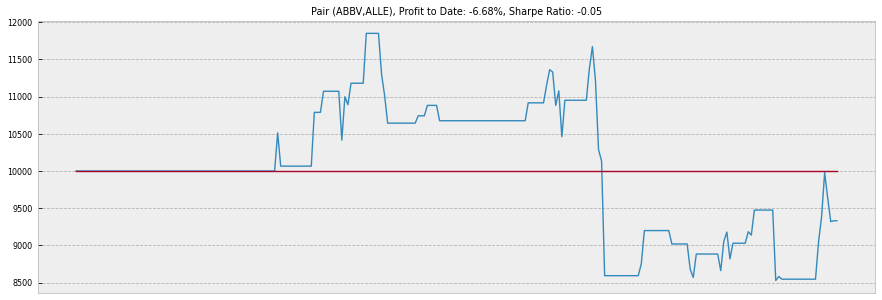

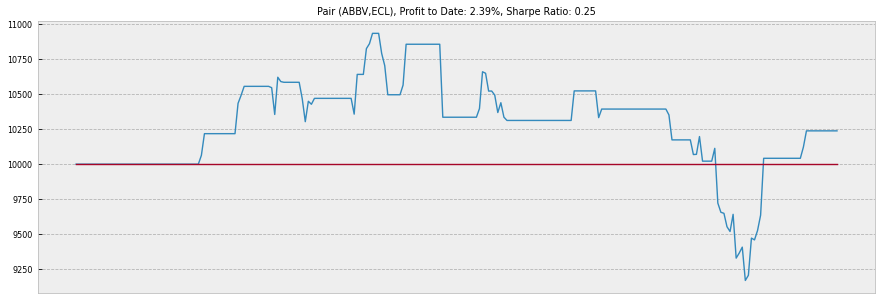

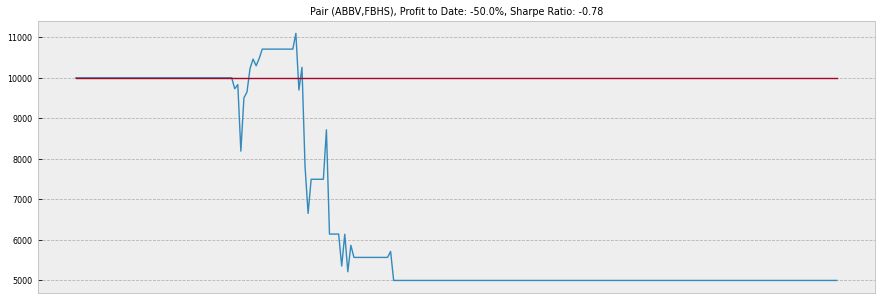

In [161]:
for stock1, stock2 in pairs[:3]: 
    port, datf= compute_returns(10000,stock1,stock2, data)

As a benchmark of the performance, we attempt our strategy on a random pair in the S&P500 index.

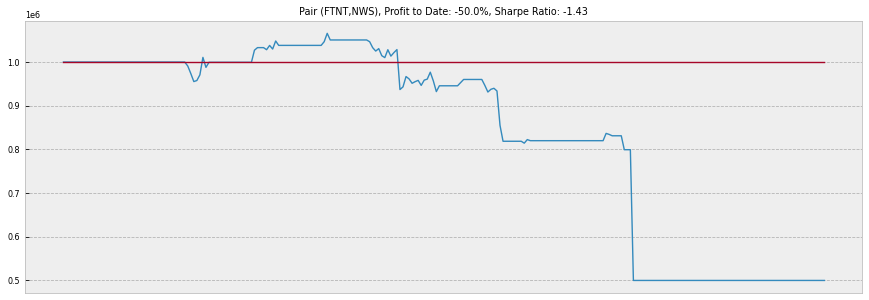

(            Positions    X  ...  Portfolio Returns  Initial Value
 date                        ...                                  
 2016-12-29          0 -0.0  ...                NaN      1000000.0
 2016-12-30          0 -0.0  ...                0.0      1000000.0
 2017-01-03          0 -0.0  ...                0.0      1000000.0
 2017-01-04          0 -0.0  ...                0.0      1000000.0
 2017-01-05          0 -0.0  ...                0.0      1000000.0
 ...               ...  ...  ...                ...            ...
 2017-12-21          0 -0.0  ...                0.0      1000000.0
 2017-12-22          0 -0.0  ...                0.0      1000000.0
 2017-12-26          0 -0.0  ...                0.0      1000000.0
 2017-12-27          0 -0.0  ...                0.0      1000000.0
 2017-12-28          0 -0.0  ...                0.0      1000000.0
 
 [252 rows x 9 columns],
                 X       Y    cov    var  ...  Clear Short  Exit  In Long  In Short
 date             

In [162]:
rand_ticker1, rand_ticker2 = np.random.choice(test_data.columns, 2)
compute_returns(1e6, rand_ticker1, rand_ticker2, test_data)

So far in our implementation we have not incorporated the costs associated with trading. We now attempt to estimate the slippage. The transaction costs are assumed fixed.

# Estimating bid-ask spread without intraday information

In this section, we include an algorithm that estimates the size of the bid-ask spread of a stock's price given only daily date. We follow [Corwin and Schultz (2012)](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1540-6261.2012.01729.x) (CS) method for estimating volatilities and bid-ask spreads from OHLCV data.

## Mathematical details

We just provide few mathematical details illustrating the CS method. The estimator used is High-Low estimator, which is asssumed to combine information about volatity of the stock and its bid ask-spread. The main underlying assumptions, which allow to estimate these two contributions, are

* daily high (resp. low) prices are buyer (resp. seller) - initiated trades.
* high-low price variance's component in High-Low grows proportionately to the length of the trading interval, while bid-ask does not.

To leverage the second property, CS uses 2-day period. Introduce the notation:

* $S$ - spread, assumed constant over 2-day periods. This means that for each transaction on a stock bought (resp. sold), we pay (resp. gain) $S/2$% 'extra' (resp. 'less). 
* $\beta$ - the expected squared return over a 2-day period:

$$
  \mathbb{E}\Big[\ln^2\frac{H_t}{L_t} + \ln^2\frac{H_{t+1}}{L_{t+1}}\Big] ,
$$
where $H_t$ and $L_t$ are the observed prices at time period $t$.

* Let $\alpha$ be given by 
$$
\alpha = \frac{\sqrt{2\beta}-\sqrt{\beta}}{3-2\sqrt{2}} - \sqrt{\frac{\gamma}{3-2\sqrt{2}}},
$$
where $\gamma$ is the "max-min return" squared over a two day-period:
$$
\gamma  = \ln^2 \Big(\frac{\max(H_{t},H_{t+1})}{\max(L_{t},L_{t+1})}\Big)
$$

Then, under some assumptions, Corwin and Schultz propose that 
$$
S =2\frac{e^{\alpha}-1}{1+e^\alpha}.
$$

Despite indimidating-looking, the formula for $\alpha$ is convenient since it is closed form and allows for direct substitution for $S$.


## Estimating the parameters of the spread

For $\beta$, we estimate the average as a rolling average for a 30-day period (monthly), i.e. 21 trading days. We incorporate a few of the adjustments of Corwin and Schultz, namely

* To account for overnight changes in price, we adjust as follows:
 1. If $L_{t+1}>H_t$, we decrease both $H_{t+1}$ and $L_{t+1}$ by $L_{t+1}-H_t$
 2. If $L_t>H_{t+1}$, we increase both $H_{t+1}$ and $L_{t+1}$ by $L_{t}-H_{t+1}$.

* All negative 2-day spreads are set to zero before calculating monthly averages. This occurs when $\alpha<0$. For example, thi is if the observed 2-day variance is more than twice as large as the single day one, traditionally when there is a lot of volatility in the markets.
 


In [163]:
raw_data.head(5)

high                         ...     low                     
ticker          A    AAL     AAP    AAPL  ...     ZBH   ZBRA   ZION    ZTS
date                                      ...                             
2016-01-04  41.19  41.35  154.48  26.343  ...  100.17  65.62  26.23  46.75
2016-01-05  40.95  41.49  153.79  26.462  ...  101.60  64.62  26.24  47.28
2016-01-06  40.99  41.70  150.05  25.593  ...  102.37  61.55  25.47  47.26
2016-01-07  40.15  41.52  149.46  25.032  ...  101.43  58.11  24.81  46.29
2016-01-08  39.71  41.36  149.44  24.778  ...  101.37  58.97  24.55  45.65

[5 rows x 994 columns]

In [164]:
# Get daily High/Low
raw_inpairs_high = raw_data['high'][data.columns]
raw_inpairs_low = raw_data['low'][data.columns]

In [165]:
# Adjust Prices according to conditions 1. and 2.
raw_inpairs_adj_low = raw_inpairs_low.copy()
raw_inpairs_adj_high = raw_inpairs_high.copy()

for ix in range(len(raw_inpairs_low)-1):
    rows_cond1 = raw_inpairs_low.iloc[ix][raw_inpairs_low.iloc[ix+1] > raw_inpairs_high.iloc[ix]].index
    rows_cond2 = raw_inpairs_low.iloc[ix][raw_inpairs_low.iloc[ix] > raw_inpairs_high.iloc[ix+1]].index
    
    raw_inpairs_adj_low.iloc[ix+1][rows_cond1] -= (raw_inpairs_low.iloc[ix+1] - raw_inpairs_high.iloc[ix])[rows_cond1]
    raw_inpairs_adj_high.iloc[ix+1][rows_cond1] -= (raw_inpairs_low.iloc[ix+1] - raw_inpairs_high.iloc[ix])[rows_cond1]
    
    raw_inpairs_adj_low.iloc[ix+1][rows_cond1] += (raw_inpairs_low.iloc[ix] - raw_inpairs_high.iloc[ix+1])[rows_cond1]
    raw_inpairs_adj_high.iloc[ix+1][rows_cond1] += (raw_inpairs_low.iloc[ix] - raw_inpairs_high.iloc[ix+1])[rows_cond1]


In [166]:
# Calculate beta
T = 21
SHIFT = 22
beta_df = pd.DataFrame(index=raw_inpairs_high.index, columns = data.columns)

# Shift indices so we always have a positive index
for t in range(SHIFT, len(beta_df.index)):
    val = 0
    for ix in range(0,T):
        val += np.log(raw_inpairs_adj_high.iloc[t-T-1+ix]/raw_inpairs_adj_low.iloc[t-T-1+ix])**2 +\
              np.log(raw_inpairs_adj_high.iloc[t-T+ix]/raw_inpairs_adj_low.iloc[t-T+ix])**2

    val*= (1/T)
    beta_df.iloc[t] = val
beta_df = beta_df.iloc[SHIFT:]
beta_df.fillna(method='ffill')
beta_df = beta_df.apply(pd.to_numeric)
beta_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AMGN,AMP,AMT,AMZN,ANET,ANSS,ANTM,AOS,APA,APD,...,UPS,URI,USB,V,VFC,VIAC,VLO,VMC,VNO,VRSK,VRSN,VTR,VTRS,VZ,WAB,WAT,WDC,WEC,WELL,WFC,WHR,WLTW,WM,WMB,WMT,WRB,WRK,WST,WU,WY,WYNN,XEL,XLNX,XOM,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-02-04,0.002,0.005,0.003,0.002,0.005,9.215e-04,0.004,0.002,0.001,0.002,0.002,0.002,9.611e-04,0.004,0.001,0.001,0.004,0.001,0.001,9.005e-04,0.001,0.004,0.004,0.004,0.004,8.338e-04,0.002,0.003,1.068e-07,0.016,0.003,0.004,0.001,0.003,0.007,0.001,0.002,0.004,0.009,0.002,...,8.421e-04,0.009,0.001,0.002,0.002,0.003,0.006,0.003,0.002,0.001,0.002,0.002,0.004,9.942e-04,0.002,0.002,0.007,0.001,0.002,0.001,0.003,0.002,7.628e-04,0.046,0.001,0.001,0.006,0.002,0.002,0.002,0.011,0.001,0.002,0.002,0.001,0.001,0.002,0.005,0.003,0.002
2016-02-05,0.002,0.005,0.002,0.002,0.005,1.291e-03,0.004,0.002,0.001,0.002,0.002,0.002,9.757e-04,0.005,0.001,0.001,0.004,0.001,0.001,8.928e-04,0.001,0.004,0.004,0.004,0.005,9.120e-04,0.002,0.003,5.338e-08,0.016,0.003,0.004,0.001,0.003,0.007,0.001,0.002,0.004,0.009,0.002,...,8.531e-04,0.009,0.001,0.002,0.002,0.003,0.007,0.003,0.002,0.001,0.002,0.002,0.004,1.012e-03,0.002,0.002,0.007,0.001,0.002,0.001,0.003,0.002,8.016e-04,0.046,0.001,0.001,0.006,0.002,0.002,0.002,0.011,0.002,0.002,0.002,0.002,0.001,0.002,0.005,0.004,0.002
2016-02-08,0.002,0.005,0.002,0.002,0.006,1.723e-03,0.005,0.002,0.001,0.002,0.002,0.002,9.999e-04,0.005,0.001,0.001,0.004,0.001,0.002,8.772e-04,0.001,0.004,0.004,0.004,0.005,9.706e-04,0.002,0.003,0.000e+00,0.016,0.003,0.004,0.001,0.004,0.007,0.002,0.002,0.004,0.009,0.002,...,8.596e-04,0.009,0.001,0.002,0.002,0.003,0.007,0.003,0.002,0.001,0.002,0.002,0.004,1.014e-03,0.003,0.002,0.008,0.001,0.002,0.001,0.003,0.002,7.984e-04,0.046,0.001,0.001,0.006,0.002,0.002,0.002,0.010,0.002,0.002,0.002,0.002,0.002,0.002,0.005,0.004,0.002
2016-02-09,0.002,0.005,0.003,0.002,0.006,1.778e-03,0.008,0.002,0.001,0.003,0.002,0.003,1.045e-03,0.005,0.001,0.001,0.004,0.001,0.002,8.718e-04,0.001,0.004,0.004,0.005,0.005,9.823e-04,0.003,0.003,0.000e+00,0.016,0.003,0.004,0.002,0.004,0.007,0.002,0.003,0.005,0.009,0.002,...,8.958e-04,0.009,0.001,0.002,0.002,0.003,0.008,0.003,0.002,0.001,0.002,0.002,0.004,1.028e-03,0.003,0.002,0.008,0.001,0.002,0.001,0.003,0.002,8.058e-04,0.053,0.001,0.001,0.006,0.002,0.002,0.003,0.011,0.002,0.002,0.002,0.002,0.002,0.002,0.005,0.004,0.002
2016-02-10,0.002,0.005,0.003,0.002,0.006,1.785e-03,0.009,0.002,0.001,0.004,0.002,0.003,1.064e-03,0.006,0.001,0.001,0.004,0.001,0.002,8.644e-04,0.001,0.004,0.004,0.006,0.005,9.731e-04,0.003,0.003,0.000e+00,0.015,0.003,0.004,0.002,0.004,0.007,0.002,0.003,0.005,0.009,0.002,...,9.455e-04,0.010,0.001,0.002,0.002,0.003,0.008,0.004,0.002,0.002,0.002,0.002,0.004,1.043e-03,0.003,0.002,0.009,0.001,0.003,0.001,0.003,0.002,8.420e-04,0.059,0.001,0.001,0.006,0.002,0.002,0.003,0.010,0.002,0.002,0.002,0.002,0.002,0.002,0.005,0.004,0.002


In [167]:
gamma_df = pd.DataFrame(index=raw_inpairs_high.index, columns =data.columns)

for t in range(1, len(gamma_df.index)):
    gamma_df.iloc[t] = np.log(np.maximum(raw_inpairs_adj_high.iloc[t-1],raw_inpairs_adj_high.iloc[t])\
                         /np.maximum(raw_inpairs_adj_low.iloc[t-1],raw_inpairs_adj_low.iloc[t]))**2

gamma_df = gamma_df[SHIFT:]
gamma_df.fillna(method='ffill')
gamma_df = gamma_df.apply(pd.to_numeric)


In [168]:
alpha_df = pd.DataFrame(index=gamma_df.index, columns = data.columns)
alpha_df = (np.sqrt(2*beta_df)-np.sqrt(beta_df))/(3-2*np.sqrt(2)) - np.sqrt(gamma_df/(3-2*np.sqrt(2)))
alpha_df.fillna(method='ffill')
alpha_df = alpha_df.apply(pd.to_numeric)


In [169]:
spreads_df = pd.DataFrame(index=alpha_df.index, columns =  data.columns)


spreads_df = 2*(np.exp(alpha_df) - 1)/(1+np.exp(alpha_df))
spreads_df[spreads_df < 0] = 0
spreads_df.head(5)

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AMGN,AMP,AMT,AMZN,ANET,ANSS,ANTM,AOS,APA,APD,...,UPS,URI,USB,V,VFC,VIAC,VLO,VMC,VNO,VRSK,VRSN,VTR,VTRS,VZ,WAB,WAT,WDC,WEC,WELL,WFC,WHR,WLTW,WM,WMB,WMT,WRB,WRK,WST,WU,WY,WYNN,XEL,XLNX,XOM,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-02-04,0.048,0.043,0.009,0.051,0.092,0.027,0.067,0.055,0.002,0.033,0.051,0.020,0.025,0.047,0.019,0.025,0.045,0.006,0.013,0.019,0.032,0.074,0.014,0.109,8.824e-02,0.000,0.039,0.063,7.888e-04,0.148,0.079,0.096,0.041,0.000,0.131,0.036,0.035,0.073,0.034,2.494e-02,...,0.024,0.075,0.026,0.039,0.036,0.003,0.000,0.035,0.034,0.000,0.015,0.042,0.056,0.030,0.000,0.049,0.041,0.035,0.070,0.021,0.068,0.070,0.029,0.326,0.000,0.032,0.077,0.039,0.034,0.048,0.089,0.048,0.059,0.036,0.000,0.030,0.059,0.029,0.039,0.051
2016-02-05,0.049,0.045,0.072,0.050,0.094,0.000,0.000,0.059,0.043,0.044,0.052,0.064,0.033,0.060,0.019,0.031,0.047,0.053,0.044,0.027,0.043,0.076,0.017,0.110,8.895e-02,0.018,0.040,0.065,5.578e-04,0.149,0.079,0.098,0.043,0.051,0.133,0.036,0.028,0.076,0.041,6.159e-02,...,0.025,0.080,0.055,0.041,0.015,0.006,0.095,0.027,0.033,0.049,0.025,0.060,0.060,0.034,0.000,0.049,0.044,0.034,0.069,0.033,0.055,0.067,0.031,0.345,0.027,0.046,0.071,0.048,0.039,0.050,0.096,0.049,0.060,0.069,0.000,0.000,0.066,0.033,0.042,0.055
2016-02-08,0.006,0.043,0.045,0.022,0.017,0.003,0.000,0.034,0.000,0.000,0.005,0.063,0.016,0.000,0.005,0.014,0.042,0.053,0.025,0.031,0.051,0.080,0.064,0.075,0.000e+00,0.030,0.000,0.019,0.000e+00,0.188,0.037,0.055,0.028,0.002,0.076,0.000,0.037,0.043,0.116,6.330e-02,...,0.012,0.107,0.055,0.002,0.032,0.005,0.006,0.030,0.039,0.033,0.027,0.060,0.065,0.035,0.016,0.047,0.030,0.016,0.060,0.034,0.055,0.000,0.027,0.297,0.028,0.041,0.074,0.028,0.040,0.000,0.138,0.017,0.047,0.030,0.025,0.000,0.060,0.016,0.056,0.062
2016-02-09,0.010,0.045,0.044,0.053,0.093,0.035,0.000,0.055,0.002,0.000,0.039,0.002,0.034,0.000,0.022,0.040,0.052,0.033,0.047,0.013,0.050,0.000,0.020,0.000,6.510e-04,0.034,0.007,0.031,0.000e+00,0.140,0.052,0.073,0.000,0.031,0.000,0.000,0.000,0.060,0.128,6.940e-04,...,0.008,0.099,0.027,0.000,0.034,0.004,0.099,0.000,0.000,0.000,0.000,0.000,0.050,0.028,0.072,0.000,0.000,0.038,0.000,0.022,0.048,0.057,0.006,0.000,0.014,0.038,0.069,0.042,0.021,0.027,0.068,0.029,0.060,0.031,0.019,0.032,0.000,0.048,0.009,0.032
2016-02-10,0.027,0.098,0.045,0.046,0.089,0.032,0.151,0.045,0.048,0.027,0.053,0.059,0.020,0.090,0.046,0.028,0.052,0.029,0.047,0.006,0.051,0.033,0.082,0.024,1.716e-04,0.035,0.036,0.076,0.000e+00,0.105,0.081,0.087,0.048,0.057,0.099,0.021,0.061,0.105,0.081,2.146e-02,...,0.010,0.125,0.016,0.048,0.063,0.049,0.105,0.059,0.030,0.019,0.046,0.000,0.034,0.030,0.000,0.012,0.093,0.049,0.000,0.032,0.059,0.063,0.033,0.106,0.052,0.048,0.074,0.035,0.023,0.038,0.117,0.056,0.059,0.053,0.060,0.043,0.047,0.008,0.071,0.019


# Pairs Trading class and tuning


## Class 

Now that we have estimates for the bid-ask spreads, we can wrap our strategy in a class. We will also add fixed rate transaction costs and will preiodically test if the stocks are still cointegrated.

In [170]:
class PairsTrading:
  def __init__(self, data, spread_df = None, transaction_cost_pct = 0, significance  = 0.03,
                retest_coint_period = None, LOOKBACK_PERIOD=21, 
                FLOOR=-1, CEIL = 1, EXIT = 2.2, interest_rate=0, MAX_PERCENTAGE_LOSS=50):
      self.data = data
      self.spread_df = spread_df
      self.LOOKBACK_PERIOD = LOOKBACK_PERIOD
      self.FLOOR = FLOOR
      self.CEIL = CEIL
      self.EXIT = EXIT
      self.significance = significance
      self.transaction_cost_pct = transaction_cost_pct
      self.retest_coint_period = retest_coint_period
      self.spreads = spread_df is not None
      self.retest = retest_coint_period is not None
      self.interest_rate = interest_rate
      self.MAX_PERCENTAGE_LOSS = MAX_PERCENTAGE_LOSS
  
  def test_coint_pairs(self, ticker_a, ticker_b, start, end):
      '''Tests if the stocks are still cointegraated'''
      data = self.data
      t1 = data[ticker_a].iloc[start:end]            
      t2 = data[ticker_b].iloc[start:end]
      t1 = t1.fillna(method = 'ffill')
      t2 = t2.fillna(method = 'ffill')
      score, pval, _ = coint(t1, t2)
      if pval < self.significance:
          return True
      return False
  
  def compute_returns(self, investment, ticker_a, ticker_b, plot = True, return_portfolio=False):
      data = self.data
      spreads_data = self.spread_df
      df = self.long_short_strat(ticker_a, ticker_b)
      portfolio = pd.DataFrame(index = df.index)
      portfolio['Positions'] = df['In Long'] - df['In Short']
      
      
      if self.spreads:
          sx = spreads_data.loc[data.index][ticker_a]
          sy = spreads_data.loc[data.index][ticker_b]
          df['sx'] = sx.values
          df['sy'] = sy.values
          portfolio['X'] = -1.0 * df['X'] * portfolio['Positions'] * (1 + portfolio['Positions']*df['sx']/2)
          portfolio['Y'] = df['Y'] * portfolio['Positions'] * (1 + (-1)*portfolio['Positions']*df['sy']/2)
      else:
          portfolio['Positions'] = df['In Long'] - df['In Short'] 
          portfolio['X'] = -1.0 * df['X'] * portfolio['Positions']
          portfolio['Y'] = df['Y'] * portfolio['Positions']
      
      portfolio['Total']= (portfolio['X'] + portfolio['Y']\
                              - self.transaction_cost_pct*(portfolio['X']+portfolio['Y']))*investment
      
      # Show percentage returns
      portfolio['Returns']= portfolio['Total'].pct_change()
      portfolio['Returns'].fillna(0.0, inplace = True)
      portfolio['Returns'].replace([np.inf, -np.inf], 0.0, inplace = True)
      portfolio['Returns'].replace(-1.0, 0.0, inplace = True)
      
    

      # Computing relevant statistics
      mu = portfolio['Returns'].mean()
      sigma = portfolio['Returns'].std()
      # Sharpe Ratio Annualized (250 trading days)
      sharpe = np.sqrt(250)*(mu- self.interest_rate)/sigma

        

      # Equity curve
      portfolio['Cum Prod'] = (1.0 + portfolio['Returns']).cumprod() 
      loss_indices = portfolio[portfolio['Cum Prod'] <= self.MAX_PERCENTAGE_LOSS/100].index
      if loss_indices.any():
        terminate_after = min(loss_indices)
        portfolio.at[terminate_after:, 'Cum Prod'] = self.MAX_PERCENTAGE_LOSS/100
        portfolio['Returns'] = portfolio['Cum Prod'].pct_change()
        new_mu = portfolio['Returns'].mean()
        new_sigma = portfolio['Returns'].std()
        sharpe = np.sqrt(252)*((new_mu- INTEREST_RATE)/new_sigma)

    
      # Calculate Portfolio
      portfolio['Trade Returns'] = portfolio['Total'].pct_change()
      portfolio['Portfolio Value'] = investment*portfolio['Cum Prod']
      portfolio['Portfolio Returns'] = portfolio['Portfolio Value'].pct_change()
      portfolio['Initial Value'] = investment
      returns_to_date = ((portfolio['Portfolio Value'][-1] - investment)/investment)*100
      
      if plot:
          with plt.style.context(['bmh', 'seaborn-paper']):
              plt.plot(portfolio['Portfolio Value'])
              plt.plot(portfolio['Initial Value'])
              plt.xticks([])
              plt.title("Pair ({},{}), Profit to Date: {}%, Sharpe Ratio: {}".format(
                        ticker_a,
                        ticker_b,
                        np.around(returns_to_date, 2),
                        np.around(sharpe, 2)
                        ))
              plt.show()
      if return_portfolio:
          return returns_to_date, sharpe, portfolio
      else:
          return returns_to_date, sharpe


  def create_spread(self, ticker_a, ticker_b):
      data = self.data
      df1 = data[ticker_a]
      df2 = data[ticker_b]
      df = pd.DataFrame(index = df1.index)
      df['X'] = df1
      df['Y'] = df2
      # computing the hedge ratio (beta of the strategy)
      df['cov'] = df.rolling(LOOKBACK_PERIOD).cov().unstack()['X']['Y']
      df['var'] = df['Y'].rolling(LOOKBACK_PERIOD).var()
      df['Hedge ratio'] = df['cov']/df['var']
      
      # column with spread
      df['Spread'] = df['X'] - df['Hedge ratio']*df['Y']
      return df
  
  def long_short_strat(self, ticker_a, ticker_b):
      data = self.data
      df = self.create_spread(ticker_a, ticker_b)
      df['Z-score'] = (df['Spread'] - df['Spread'].rolling(self.LOOKBACK_PERIOD).mean())\
                      /(df['Spread'].rolling(self.LOOKBACK_PERIOD).std())
      
      # Buy vs Sell signals
      df['Long'] =  (df['Z-score'] < self.FLOOR)*1
      df['Short']= (df['Z-score'] > self.CEIL)*1

      # Clear positions if the z-score drops between FLOOR/2 and CEIL/2
      df['Clear Long'] = (df['Z-score'] >self.FLOOR/2)*1 
      df['Clear Short'] = (df['Z-score'] <self.CEIL/2)*1 

      # Exit position if z-score goes above EXIT level
      df['Exit'] = (np.abs(df['Z-score'])> self.EXIT)*1
      
      
      # Test if stocks are still cointegrated
      coint_test = pd.DataFrame(index=df.index)
      if self.retest:
          for ix in range(len(df)-self.retest_coint_period):
              still_coint = self.test_coint_pairs(ticker_a, 
                                                  ticker_b, 
                                                  ix, 
                                                  ix+self.retest_coint_period)
              
              coint_test.iloc[ix:ix+self.retest_coint_period] = (not still_coint)*1
      # If stocks are not cointegrated, exit    
      df['Exit'] = df['Exit'] ^ coint_test
      
      df['In Long'] = (((df['Long'] == 1) & (~((df['Exit'] == 1) | (df['Clear Long'] == 1)))))*1
      df['In Short'] = (((df['Short'] == 1) & (~((df['Exit'] == 1) | (df['Clear Short'] == 1)))))*1

      return df



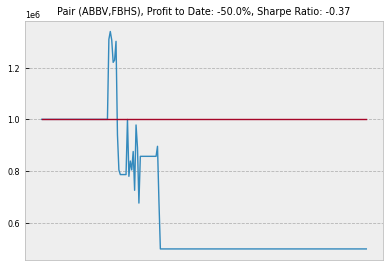

(-50.0, -0.3745991628764942)

In [171]:
pt = PairsTrading(data=data.iloc[SHIFT:],
                  spread_df=spreads_df,
                  LOOKBACK_PERIOD = LOOKBACK_PERIOD,
                  FLOOR = FLOOR,
                  CEIL = CEIL,
                  EXIT = EXIT,)
stock1, stock2 = pairs[0]
pt.compute_returns(1000000,stock1,stock2)

## Tuning the hyperparameters

Lastly, we use grid search to tune the hyperparameters of the strategy.

In [172]:
ceil = [x for x in np.arange(0.8, 1.6, 0.2)]
exit = [x for x in np.arange(1.8, 2.4, 0.2)]
retest_period = [None, 90, 180]
transaction_cost_pct = 0.02
print("Search Space Size: {}".format(len(ceil)*len(exit)*len(retest_period)))


Search Space Size: 36


In [173]:
results = []
NUM_PAIRS  = 10
investment = 1e6
for c in ceil:
    if results:
        print('Best So Far: {}'.format(max(results, key = lambda x: x[-1])))
    for ex in exit:
        for rtp in retest_period:
            pt = PairsTrading(data=data.iloc[SHIFT:],
                              spread_df=spreads_df,
                              transaction_cost_pct=transaction_cost_pct,
                              retest_coint_period=rtp,
                              FLOOR = c*-1,
                              CEIL = c,
                              EXIT = ex)
            r = []
            for pair in pairs[:NUM_PAIRS]:
                ret, shp = pt.compute_returns(investment, *pair, plot=False)
                r.append(shp)
            results.append((c,-1*c,ex,rtp,np.median(r)))

Best So Far: (0.8, -0.8, 1.8, None, -0.3711405743057543)
Best So Far: (1.0, -1.0, 1.8, None, -0.34637965345443417)
Best So Far: (1.2, -1.2, 1.8, None, -0.30976084737937104)


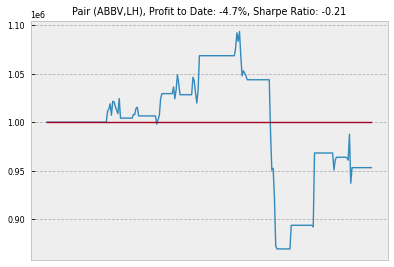

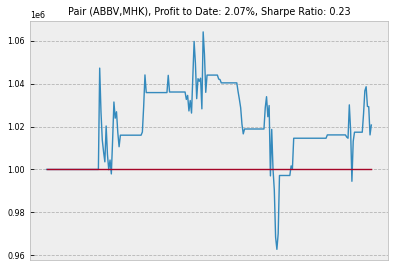

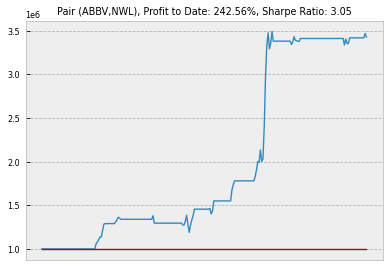

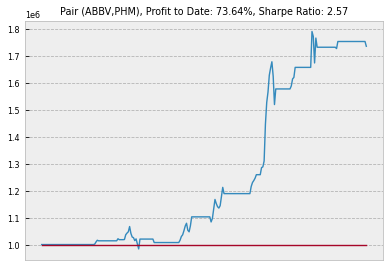

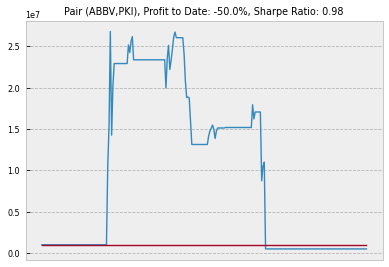

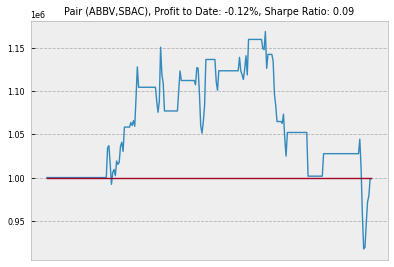

In [174]:
best = max(results, key = lambda x: x[-1])
c, f, ex, rtp, _ = best

investment = 1e6
pt_test = PairsTrading(data=test_data,
                  spread_df=spreads_df,
                  transaction_cost_pct=transaction_cost_pct,
                  retest_coint_period=rtp,
                  FLOOR = f,
                  CEIL = c,
                  EXIT = ex)

pt_train = PairsTrading(data=data[SHIFT:],
                  spread_df=spreads_df,
                  transaction_cost_pct=transaction_cost_pct,
                  retest_coint_period=rtp,
                  FLOOR = f,
                  CEIL = c,
                  EXIT = ex)


returns = []
for pair in pairs[3:9]:
    ret = pt_test.compute_returns(investment, *pair)
    returns.append(ret)

# Backtest on a basket of pair trades

We now trade a full basket of pair trades. We have weighted the strategies by their in-sample performance, where a pair with better in-sample performance, constitutes a bigger portion of our portfolio. We remove all strategies that perform below certain treshold on the test data.


In [175]:
initial_investment = 1e6
pairs_dict = {}

for pair in pairs:
  ticker_1 = pair[0]
  ticker_2 = pair[1]
  ret, shp, portfolio = pt_train.compute_returns(initial_investment, *pair, plot=False, return_portfolio=True)
  pairs_dict[pair] = ret, shp


In [176]:
threshold = 0
basket = pd.DataFrame.from_dict(pairs_dict, orient='index',columns = ["returns", "sharpe"])
basket = basket[basket['returns'] > threshold]

print("{} Pairs chosen".format(basket.shape[0]))

basket['weights'] = basket['returns']/sum(basket['returns'])

basket.head(10)

28 Pairs chosen


,returns,sharpe,weights
"(ABBV, ALLE)",8.450,0.416,9.146e-03
"(ABBV, PHM)",0.063,0.092,6.802e-05
"(ABBV, SBAC)",19.367,0.836,2.096e-02
"(ALLE, FBHS)",60.264,1.036,6.523e-02
"(ALLE, PHM)",17.827,1.376,1.930e-02
"(ALLE, TMO)",7.625,0.550,8.253e-03
"(A, AFL)",82.805,2.027,8.962e-02
"(A, BDX)",24.675,2.261,2.671e-02
"(A, BR)",79.587,1.612,8.614e-02
"(AEE, CB)",9.631,0.847,1.042e-02


In [177]:
# Sanity check. The weights must add up to 1
sum(basket['weights'])

0.9999999999999999

In [178]:
basket['allocation'] = basket['weights']*initial_investment
basket.head()

,returns,sharpe,weights,allocation
"(ABBV, ALLE)",8.450,0.416,9.146e-03,9145.772
"(ABBV, PHM)",0.063,0.092,6.802e-05,68.021
"(ABBV, SBAC)",19.367,0.836,2.096e-02,20962.019
"(ALLE, FBHS)",60.264,1.036,6.523e-02,65225.423
"(ALLE, PHM)",17.827,1.376,1.930e-02,19295.227


In [179]:
basket_returns = []

portfolios = pd.DataFrame()

for pair in basket.index:
    ret, _, port = pt_test.compute_returns(basket['allocation'][pair], 
                                           *pair, 
                                           plot=False, 
                                           return_portfolio=True)
    basket_returns.append(ret/100)
    portfolios[pair] = port['Returns']
    
basket_returns = np.array(basket_returns)
basket['money_after'] = basket['allocation']*(1+basket_returns)

In [180]:
basket.head(10)

,returns,sharpe,weights,allocation,money_after
"(ABBV, ALLE)",8.450,0.416,9.146e-03,9145.772,4572.886
"(ABBV, PHM)",0.063,0.092,6.802e-05,68.021,118.114
"(ABBV, SBAC)",19.367,0.836,2.096e-02,20962.019,20936.325
"(ALLE, FBHS)",60.264,1.036,6.523e-02,65225.423,53968.407
"(ALLE, PHM)",17.827,1.376,1.930e-02,19295.227,17128.729
"(ALLE, TMO)",7.625,0.550,8.253e-03,8252.671,9306.233
"(A, AFL)",82.805,2.027,8.962e-02,89622.375,44811.187
"(A, BDX)",24.675,2.261,2.671e-02,26706.402,28365.520
"(A, BR)",79.587,1.612,8.614e-02,86139.785,55738.455
"(AEE, CB)",9.631,0.847,1.042e-02,10424.392,11496.646


In [181]:
# Profits
print("Profits on {} investment :".format(initial_investment), sum(basket['money_after'])-initial_investment)

Profits on 1000000.0 investment : 435523.3290574588


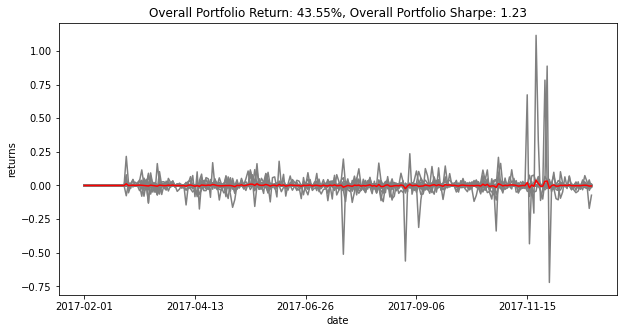

In [182]:
color_dict = {x:'#808080' for x in portfolios.columns} # Grey

portfolios['mean'] = portfolios.mean(axis=1)
color_dict['mean'] = '#FF0000' # Red

weighted_portfolios = portfolios.copy() # Introduced to compute basket sharpe ratio below

for basket_pair in portfolios.columns:
  if basket_pair!="mean":
    weighted_portfolios[basket_pair] = weighted_portfolios[basket_pair]*basket['weights'][basket_pair]

weighted_portfolios['sum'] = weighted_portfolios.sum(axis=1)

basket_sharpe = np.sqrt(250)*(weighted_portfolios['sum'].mean() - INTEREST_RATE)/weighted_portfolios['sum'].std()
overall_return =  ((sum(basket['money_after'])-investment)/investment)*100


portfolios.iloc[22:].plot(color=color_dict, 
                          legend=False, 
                          figsize=(10,5),
                          xlabel='date',
                          ylabel='returns',
                          title = "Overall Portfolio Return: {}%, Overall Portfolio Sharpe: {}".format(np.around(overall_return, 2),
                                                                   np.around(basket_sharpe,2)))